In [1]:
pip install ortools

In [2]:
import pandas as pd
import numpy as np
import random as rd
import matplotlib.pyplot as plt
from collections import defaultdict
from ortools.sat.python import cp_model
import ortools
import time

##Empresa de Consultoria

In [3]:
#Colaboradores de nossa empresa de consultoria em ordem alfabética.#
Profissionais = ['Marcelo Eihara', 'Tarcisio Almeida', 'Fabio Arnaldo', 'Washington Barbosa', 'Atahualpa Bastos', 'Rafael Calado',
                 'Katilce Delgado', 'Rafael George', 'Morgana Leite', 'Alessandre Martins', 'Luiz Gustavo Magoga', 'Leonides Neto',
                 'Diego Oliveira', 'Rildo Pereira', 'Letícia Queiroz', 'Tamires Rezende', 'João Ricardo', 'Jorge Mariz', 'Paulo Hugo', 'Carlo Revoredo']
Profissionais.sort()
print(Profissionais)

['Alessandre Martins', 'Atahualpa Bastos', 'Carlo Revoredo', 'Diego Oliveira', 'Fabio Arnaldo', 'Jorge Mariz', 'João Ricardo', 'Katilce Delgado', 'Leonides Neto', 'Letícia Queiroz', 'Luiz Gustavo Magoga', 'Marcelo Eihara', 'Morgana Leite', 'Paulo Hugo', 'Rafael Calado', 'Rafael George', 'Rildo Pereira', 'Tamires Rezende', 'Tarcisio Almeida', 'Washington Barbosa']


In [ ]:
#Respectivas funções aleatórias dos nossos colaboradores.#
Funcoes = ['Arquiteto', 'Iniciante', 'Arquiteto', 'Front-end', 'Quality Assurance', 'Quality Assurance',
                 'Iniciante', 'Iniciante', 'Back-end', 'Back-end', 'Back-end', 'Quality Assurance',
                 'Front-end', 'Front-end', 'Quality Assurance', 'Iniciante', 'Arquiteto', 'Iniciante', 'Back-end', 'Quality Assurance']
print(Funcoes)

['Back-end', 'Back-end', 'Arquiteto', 'Quality Assurance', 'Arquiteto', 'Iniciante', 'Quality Assurance', 'Arquiteto', 'Front-end', 'Back-end', 'Quality Assurance', 'Iniciante', 'Quality Assurance', 'Quality Assurance', 'Iniciante', 'Iniciante', 'Back-end', 'Iniciante', 'Front-end', 'Front-end']


In [5]:
#Matriz de performance entre os colaboradores, com notas de 1 a 10.#
Performance_individual = []
for i in range(len(Profissionais)):
  if Funcoes[i] == 'Iniciante':
    Performance_individual.append(rd.Random(i).randint(3,7))
  else:
    Performance_individual.append(rd.Random(i).randint(6,10))
  Performance_individual
print('Performance_individual')
print(Performance_individual)

Performance = defaultdict(list)
for i in range(len(Performance_individual)):
  aux = []
  for k in range(len(Performance_individual)):
    if i == k:
      aux.append(Performance_individual[i])
    else:
      aux.append((Performance_individual[i] + Performance_individual[k])//2)
  Performance[i] = aux
print("Performance[0]")
print(Performance[0])

Max_Performance = sum([Performance[i][k] for i in range(len(Profissionais)) for k in range(len(Profissionais))])
print('Max_Performance')
print(Max_Performance)

############# Corrigir Performance para uma matriz simétrica #############

Performance_individual
[9, 7, 6, 7, 7, 7, 10, 8, 7, 9, 10, 6, 9, 8, 3, 4, 8, 7, 7, 6]
Performance[0]
[9, 8, 7, 8, 8, 8, 9, 8, 8, 9, 9, 7, 9, 8, 6, 6, 8, 8, 8, 7]
Max_Performance
2801


In [6]:
#Autoexplicativo#
Conversor_Funcoes = {'Arquiteto': 0, 'Front-end': 1, 'Back-end': 2, 'Quality Assurance': 3, 'Iniciante': 4}
Funcoes_Num = [Conversor_Funcoes[x] for x in Funcoes]
print(Funcoes_Num)

[2, 2, 0, 3, 0, 4, 3, 0, 1, 2, 3, 4, 3, 3, 4, 4, 2, 4, 1, 1]


In [7]:
#Organizamos os profissionais e suas funções em um dataset para auxiliar a extração das informações.#
df = pd.DataFrame({'Profissionais': Profissionais, 'Funcoes': Funcoes, 'Funcoes_Num': Funcoes_Num, 'Performance': Performance_individual})
df.sort_values(by=['Funcoes_Num'], inplace=True)
df.reset_index(drop=True, inplace=True)
df.head()

,Profissionais,Funcoes,Funcoes_Num,Performance
0,Carlo Revoredo,Arquiteto,0,6
1,Fabio Arnaldo,Arquiteto,0,7
2,Katilce Delgado,Arquiteto,0,8
3,Leonides Neto,Front-end,1,7
4,Tarcisio Almeida,Front-end,1,7


In [8]:
#Essas são as especificações dos projetos. Optamos por testar 3 projetos.#
aux = [
[1,2,1,1,2],
[1,1,2,1,1],
[1,1,1,1,0]
]

Requisitos_Projetos = defaultdict(list)
for t in range(len(aux)):
  Requisitos_Projetos[t] = defaultdict(list)

for t in range(len(Requisitos_Projetos)):
  for j in range(len(set(Funcoes_Num))):
    Requisitos_Projetos[t][j] = aux[t][j]

Requisitos_Projetos

defaultdict(list,
            {0: defaultdict(list, {0: 1, 1: 2, 2: 1, 3: 1, 4: 2}),
             1: defaultdict(list, {0: 1, 1: 1, 2: 2, 3: 1, 4: 1}),
             2: defaultdict(list, {0: 1, 1: 1, 2: 1, 3: 1, 4: 0})})

##Otimização

Vamos criar um modelo baseado em Programação Linear Inteira (ILP).
Utilizaremos uma abordagem de Programação por Restrições (COP) para resolver o problema de alocação de recursos com maximização da sinergia.

In [9]:
#Primeiro crio meu extrator de informações do solver#
class VarArrayAndObjectiveSolutionPrinter(cp_model.CpSolverSolutionCallback):
    def __init__(self, variables, limit):
        cp_model.CpSolverSolutionCallback.__init__(self)
        self.__variables = variables
        self.__solution_count = 0
        self.__solution_limit = limit
        self.solution_list = []
        self.solution_time = []
        self.solution_objective = []
        self.best_bound = 0
        self.__start_time = time.time()
    def on_solution_callback(self):
        self.__solution_count += 1
        if self.__solution_count >= self.__solution_limit:
            self.StopSearch()
        self.solution_list.append([self.Value(v) for v in self.__variables])
        current_time = time.time()
        obj = self.ObjectiveValue()
        self.best_bound = self.BestObjectiveBound()
        self.solution_time.append(current_time - self.__start_time)
        self.solution_objective.append(obj)
        #print('Solution %i, time = %0.2f s, objective = %i' %
        #      (self.__solution_count, current_time - self.__start_time, obj))
        #for v in self.__variables:
        #    print('  %s = %i' % (v, self.Value(v)), end=' ')
    def solution_count(self):
        return self.__solution_count

In [10]:
tic = time.time()#
model = cp_model.CpModel()
COP_iterations = 100
max_runtime = 60*10 #Critério de parada temporal#

#B será uma matriz binária. Para cada projeto i, cada colaborador j Bij=1 se ele participa de i, Bij=0 caso contrário#
B = []
for i in range(len(Requisitos_Projetos)):
  aux1 = []
  for j in range(len(df['Funcoes_Num'])):
    aux1.append(model.NewBoolVar(f'B_{i}_{j}'))
  B.append(aux1)

#P será uma matriz binária de profissões. Para cada projeto i, uma profissão k pode ou não ser adequada ao colaborador j,
#tal que Pikj=1 quando houver aderência entre o profissional, sua profissão e a demanda do projeto, ou Pikj=0 caso contrário#
P = []
for i in range(len(Requisitos_Projetos)):
  aux1 = []
  for k in range(len(Requisitos_Projetos[i])):
    aux2 = []
    for j in range(len(df['Funcoes_Num'])):
      aux2.append(model.NewBoolVar(f'P_{i}_{k}_{j}'))
    aux1.append(aux2)
  P.append(aux1)

#S será uma matriz inteira. Cada projeto i receberá a Performance correspondente à atribuição do time#
S = []
for i in range(len(Requisitos_Projetos)):
  aux1 = []
  for j in range(len(df['Funcoes_Num'])):
    aux2 = []
    for t in range(len(df['Funcoes_Num'])):
      aux2.append(model.NewIntVar(0, Max_Performance, f'S_{i}_{j}_{t}'))
    aux1.append(aux2)
  S.append(aux1)

#Restrição 1: #
#Nenhum profissional pode ser alocado em mais de 2 projetos#
for j in range(len(df['Funcoes_Num'])):
  model.Add(cp_model.LinearExpr.Sum([B[i][j] for i in range(len(Requisitos_Projetos))]) <= 2)

#Restrição 2: #
#Cada projeto não pode receber a atribuição de um número diferente de profissionais que o pré-determinado para cada função#
for i in range(len(Requisitos_Projetos)):
  for k in range(len(Requisitos_Projetos[i])):
    model.Add(cp_model.LinearExpr.Sum([P[i][k][j] for j in range(len(df['Funcoes_Num']))]) == Requisitos_Projetos[i][k])

#Restrições 3, 4 e 5: #
#Garanto que um profissional não tenha sobrecarga caso outro com mesma função esteja ocioso#
for j in range(len(df['Funcoes_Num'])):
  x_var = model.NewBoolVar(f'x_var_{j}')
  model.Add(cp_model.LinearExpr.Sum([B[i][j] for i in range(len(Requisitos_Projetos))]) >= 1).OnlyEnforceIf(x_var)
  model.Add(cp_model.LinearExpr.Sum([B[i][j] for i in range(len(Requisitos_Projetos))]) == 0).OnlyEnforceIf(x_var.Not())
  for t in range(len(df['Funcoes_Num'])):
    if df['Funcoes_Num'][j] == df['Funcoes_Num'][t] and j != t:
      model.Add(cp_model.LinearExpr.Sum([B[i][t] for i in range(len(Requisitos_Projetos))]) <= 1).OnlyEnforceIf(x_var.Not())

#Restrições 6 e 7: #
#Determino uma conexão entre as variáveis Bij com Pikj#
for i in range(len(Requisitos_Projetos)):
  for j in range(len(df['Funcoes_Num'])):
    model.Add(cp_model.LinearExpr.Sum([P[i][k][j] for k in range(len(Requisitos_Projetos[i]))]) == 1).OnlyEnforceIf(B[i][j])
    model.Add(cp_model.LinearExpr.Sum([P[i][k][j] for k in range(len(Requisitos_Projetos[i]))]) == 0).OnlyEnforceIf(B[i][j].Not())

#Restrição 8: #
#Os profissionais atribuídos a cada função devem corresponder exatamente à expectativa dos cargos#
#Para definir esta restrição, primeiro devemos criar uma variável auxiliar booleana z_var#
#z_var = 1 quando uma dada função é desejada em um projeto, ou z_var = 0 caso contrário#
#Mais adiante, forçamos que B[i][j] > 0 somente quando z_var = 1#
for i in range(len(Requisitos_Projetos)):
  for k in range(len(Requisitos_Projetos[i])):
    for j in range(len(df['Funcoes_Num'])):
      y_var = model.NewBoolVar(f'y_var_{i}_{k}_{j}')
      model.Add(k == df['Funcoes_Num'][j]).OnlyEnforceIf(y_var)
      model.Add(k != df['Funcoes_Num'][j]).OnlyEnforceIf(y_var.Not())
      model.Add(P[i][k][j] >= 0).OnlyEnforceIf(y_var)
      model.Add(P[i][k][j] == 0).OnlyEnforceIf(y_var.Not())


#Gostaria de computadar a similaridade somente daqueles funcionário atribuídos a um mesmo projeto#
#Entretanto, uma multiplicar B[i][j] x B[i][k] resultaria em um problema não linear, fora do espoco desejado#
#neste intuito, criamos uma variável s a ser otimizada, atendendo à nossa demandas sem multiplicar diretamente B1 x B2#
objective_terms = []
for i in range(len(Requisitos_Projetos)):
  for j in range(len(df['Funcoes_Num'])):
    aux_bool = model.NewBoolVar(f'constr_{i}_{j}')
    model.Add(B[i][j] == 1).OnlyEnforceIf(aux_bool)
    model.Add(B[i][j] == 0).OnlyEnforceIf(aux_bool.Not())
    for t in range(len(df['Funcoes_Num'])):
      aux_bool2 = model.NewBoolVar(f'constr_{i}_{t}')
      model.Add(B[i][t] == 1).OnlyEnforceIf(aux_bool2)
      model.Add(B[i][t] == 0).OnlyEnforceIf(aux_bool2.Not())
      if j != t:
        s = model.NewBoolVar(f's_{i}_{j}_{t}')
        model.AddBoolOr(aux_bool.Not(), aux_bool2.Not(), s)
        model.AddImplication(s, aux_bool)
        model.AddImplication(s, aux_bool2)
        objective_terms.append(int(Performance[j][t]*10/2) * s)
        model.Add(S[i][j][t] == int(Performance[j][t]*10/2)).OnlyEnforceIf(s)
        model.Add(S[i][j][t] == 0).OnlyEnforceIf(s.Not())
      #else:
      #  model.Add(S[i][j][t] == 0)

#Função objetivo que visa maximizar a sinergia em todos os projetos#
model.Maximize(cp_model.LinearExpr.Sum(objective_terms))
solver = cp_model.CpSolver()
solution_collector = VarArrayAndObjectiveSolutionPrinter([S[i][j][t] for i in range(len(Requisitos_Projetos)) for j in range(len(df['Funcoes_Num'])) for t in range(len(df['Funcoes_Num']))],
                                                         COP_iterations)
solver.parameters.max_time_in_seconds = max_runtime
solver.parameters.log_search_progress = True
#solver.parameters.num_search_workers = 1
solver.log_callback = print
status = solver.Solve(model, solution_collector)
solution_collector.solution_list
solution_collector.solution_time
solution_collector.solution_objective
#solver.parameters.exploit_best_solution = 130

tac = time.time()#
sec1 = tac - tic#
print('Time =',sec1)
print('Status =', solver.StatusName(status))
print('FO =', solver.ObjectiveValue())

B_Array = []
for i in range(len(Requisitos_Projetos)):
  aux1 = []
  for j in range(len(df['Funcoes_Num'])):
    aux1.append(solver.Value(B[i][j]))
  B_Array.append(aux1)

S_Array = []
for i in range(len(Requisitos_Projetos)):
  aux1 = []
  for j in range(len(df['Funcoes_Num'])):
    aux2 = []
    for t in range(len(df['Funcoes_Num'])):
      aux2.append(int(solver.Value(S[i][j][t])/10))
    aux1.append(aux2)
  S_Array.append(aux1)


Starting CP-SAT solver v9.12.4544
Parameters: max_time_in_seconds: 600 log_search_progress: true
Setting number of workers to 2

Initial optimization model '': (model_fingerprint: 0x59db997d0d139e39)
#Variables: 4'281 (#bools: 1'140 in objective)
  - 3'080 Booleans in [0,1]
  - 1'200 in [0,2801]
  - 1 constants in {1} 
#kBoolOr: 4'020 (#enforced: 2'880) (#literals: 6'000)
#kLinear1: 5'400 (#enforced: 5'400)
#kLinear3: 124 (#enforced: 104)
#kLinearN: 135 (#enforced: 120) (#terms: 900)

Starting presolve at 0.01s
  3.03e-03s  0.00e+00d  [DetectDominanceRelations] 
  4.99e-02s  0.00e+00d  [PresolveToFixPoint] #num_loops=4 #num_dual_strengthening=2 
  1.44e-04s  0.00e+00d  [ExtractEncodingFromLinear] #potential_supersets=12 
  6.64e-04s  0.00e+00d  [DetectDuplicateColumns] 
  1.19e-03s  0.00e+00d  [DetectDuplicateConstraints] 
[Symmetry] Graph for symmetry has 9'746 nodes and 16'409 arcs.
[Symmetry] Symmetry computation done. time: 0.00925049 dtime: 0.00523158
[Symmetry] #generators: 3, a

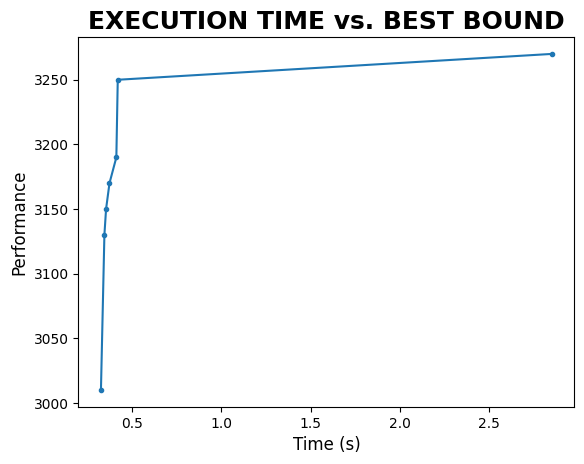

In [11]:
X= solution_collector.solution_time
Y= solution_collector.solution_objective

plt.scatter(X, Y, s=9)
plt.plot(X, Y)
plt.title("EXECUTION TIME vs. BEST BOUND", fontweight="bold", fontsize=18)
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Performance', fontsize=12)
plt.show()

In [21]:
print('Número de Iterações:')
len(solution_collector.solution_objective)

Número de Iterações:


7

In [12]:
for i in range(len(Requisitos_Projetos)):
  print(B_Array[i])
print('Performance_individual')
print(Performance_individual)

[1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0]
[0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
[0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
Performance_individual
[9, 7, 6, 7, 7, 7, 10, 8, 7, 9, 10, 6, 9, 8, 3, 4, 8, 7, 7, 6]


In [13]:
proj = 0
aux1 = [S_Array[proj][j] for j in range(len(Funcoes_Num))]
aux2 = [sum(aux1[k]) for k in range(len(Funcoes_Num))]
print(aux2)
print('Performance atribuída ao projeto 1:')
print(sum(aux2))

[24, 0, 0, 0, 21, 21, 0, 0, 0, 24, 0, 0, 24, 0, 0, 0, 0, 21, 21, 0]
Performance atribuída ao projeto 1:
156


In [14]:
#Validação para o indivíduo 0 no projeto 0
(Performance[0][4] + Performance[0][5] + Performance[0][9] + Performance[0][12] + Performance[0][17] + Performance[0][18])//2
#Devia ser 24 seu desempenho, mas há arredondamentos para que a abordagem constraint programming funcione, de modo que pequenas diferenças podem ocorrer.

25

In [15]:
#Validando se o cálculo da Performance está correto#
aux3 = []
for j in range(len(Funcoes_Num)):
  if aux2[j] != 0:
    aux3.append(j)

aux4 = []
for j in aux3:
  for k in aux3:
    if j != k:
      aux4.append(int(Performance[j][k]/2))
print('Performance calculada no dataset:')
print(sum(aux4))

Performance calculada no dataset:
156


In [16]:
Proj1, Proj2, Proj3 = [], [], []
for t in range(len(Requisitos_Projetos)):
  for j in range(len(df['Funcoes_Num'])):
    if t == 0:
      Proj1.append(B_Array[t][j])
    elif t == 1:
      Proj2.append(B_Array[t][j])
    else:
      Proj3.append(B_Array[t][j])

print(Proj1)
print(Proj2)
print(Proj3)

[1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0]
[0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
[0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]


In [17]:
df['Projeto 1'] = Proj1
df['Projeto 2'] = Proj2
df['Projeto 3'] = Proj3
df

,Profissionais,Funcoes,Funcoes_Num,Performance,Projeto 1,Projeto 2,Projeto 3
0,Carlo Revoredo,Arquiteto,0,6,1,0,0
1,Fabio Arnaldo,Arquiteto,0,7,0,0,1
2,Katilce Delgado,Arquiteto,0,8,0,1,0
3,Leonides Neto,Front-end,1,7,0,1,0
4,Tarcisio Almeida,Front-end,1,7,1,0,0
5,Washington Barbosa,Front-end,1,6,1,0,1
6,Atahualpa Bastos,Back-end,2,7,0,1,0
7,Alessandre Martins,Back-end,2,9,0,1,0
8,Letícia Queiroz,Back-end,2,9,0,0,1
9,Rildo Pereira,Back-end,2,8,1,0,0


In [18]:
df2 = pd.DataFrame([Proj1,Proj2,Proj3])
df2.columns = df['Profissionais']
df2.index = ['Projeto 1', 'Projeto 2', 'Projeto 3']
df2

Profissionais,Carlo Revoredo,Fabio Arnaldo,Katilce Delgado,Leonides Neto,Tarcisio Almeida,Washington Barbosa,Atahualpa Bastos,Alessandre Martins,Letícia Queiroz,Rildo Pereira,Paulo Hugo,Morgana Leite,Luiz Gustavo Magoga,João Ricardo,Diego Oliveira,Jorge Mariz,Rafael George,Rafael Calado,Marcelo Eihara,Tamires Rezende
Projeto 1,1,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0,0,1,1,0
Projeto 2,0,0,1,1,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0
Projeto 3,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0


In [19]:
df2

Profissionais,Carlo Revoredo,Fabio Arnaldo,Katilce Delgado,Leonides Neto,Tarcisio Almeida,Washington Barbosa,Atahualpa Bastos,Alessandre Martins,Letícia Queiroz,Rildo Pereira,Paulo Hugo,Morgana Leite,Luiz Gustavo Magoga,João Ricardo,Diego Oliveira,Jorge Mariz,Rafael George,Rafael Calado,Marcelo Eihara,Tamires Rezende
Projeto 1,1,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0,0,1,1,0
Projeto 2,0,0,1,1,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0
Projeto 3,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0


In [22]:
df.to_csv('Profissionais.csv')
df2.to_csv('Projetos.csv')